# Forward prediction of hate speech scores of Twitter replies

## Installs and imports

In [1]:
!pip install --upgrade pip
!pip install sentencepiece
!pip install datasets
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 7.2 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.7/468.7 kB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 24.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 51.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 kB 19.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 kB 29.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 16.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 kB 23.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 kB 1

In [2]:
from transformers import AutoTokenizer, AutoConfig, AutoModelForSequenceClassification

from matplotlib import pyplot as plt
from matplotlib.font_manager import FontProperties

from scipy.special import softmax
from torch.utils.data import DataLoader

import numpy as np
import pandas as pd

## Load the Twitter datasets
> These are the datasets over which sentiment analysis has already been performed

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Replies to Laroutrou

In [4]:
df1 = pd.read_csv (
    '/content/drive/My Drive/Twitter-Sentiment-Hate/replies-larrouturou-annotated-botometer-sentiment.csv',
    low_memory=False,  
    lineterminator='\n', 
    sep=',',)
    #error_bad_lines=False)

In [5]:
df1.shape

(171, 50)

Replies to Alviina

In [6]:
df2 = pd.read_csv (
    '/content/drive/My Drive/Twitter-Sentiment-Hate/replies-alviinaalametsa-annotated-botometer-sentiment.csv',
    low_memory=False,  
    lineterminator='\n', 
    sep=',',) 
    #error_bad_lines=False)

In [7]:
df2.shape

(113, 50)

In [9]:
df1.columns

Index(['id', 'conversation_id', 'created_at', 'date', 'timezone', 'place',
       'tweet', 'language', 'hashtags', 'cashtags', 'user_id', 'user_id_str',
       'username', 'name', 'day', 'hour', 'link', 'urls', 'photos', 'video',
       'thumbnail', 'retweet', 'nlikes', 'nreplies', 'nretweets', 'quote_url',
       'search', 'near', 'geo', 'source', 'user_rt_id', 'user_rt',
       'retweet_id', 'reply_to', 'retweet_date', 'translate', 'trans_src',
       'trans_dest', 'sentiment', 'annotator', 'annotation_id', 'updated_at',
       'lead_time', 'botometerCapEng.score', 'botometerCapUni.score',
       'botometerOverallRawEng.score', 'botometerOverallRawUni.score',
       'botometerDisplayEng.score', 'botometerDisplayUni.score',
       'tweetSentiment.score'],
      dtype='object')

## Data preprocessing

Extract particular columns and convert into lists

In [10]:
tweet_list1 = df1 ['tweet'].tolist()
tweet_list2 = df2 ['tweet'].tolist()

print ("Total number of entries in the first dataset:", len(tweet_list1))
print ("Total number of entries in the second dataset:", len(tweet_list2))

Total number of entries in the first dataset: 171
Total number of entries in the second dataset: 113


## Load the hate speech analysis model and the tokenizer


Define parameters

In [11]:
CUDA = True # set to true if using GPU (Runtime -> Change runtime Type -> GPU)

BATCH_SIZE = 16

labels_ids = {'non-hate': 0, 'hate': 1}

n_labels = len(labels_ids)

max_length = 312

MODEL = "Rewire/XTC"

Load the model and the tokenizer

In [12]:
tokenizer = AutoTokenizer.from_pretrained(MODEL, use_fast=True)

config = AutoConfig.from_pretrained(MODEL) # used for id to label name (optional)

model = AutoModelForSequenceClassification.from_pretrained(MODEL)

if CUDA:
  model = model.to('cuda')
_ = model.eval()

## Define the forward prediction functions

In [13]:
def forward (text, cuda=True):
  encoded_input = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length = max_length)
  if cuda:
    encoded_input.to('cuda')
    output = model(**encoded_input)
    scores = output[0].detach().cpu().numpy()
  else:
    output = model(**encoded_input)
    scores = output[0].detach().numpy()
  
  scores = softmax(scores, axis=-1)
  return scores

In [15]:
def hatespeech_pred_score (data_list):
  dl = DataLoader(data_list, batch_size=BATCH_SIZE)
  hate_pred = []

  for idx, batch in enumerate(dl):
    if idx % 1 == 0:
      print('Batch ',idx+1,' of ', len(dl))

    scores = forward(batch, cuda=CUDA)
    preds = np.argmax(scores, axis=-1)
    hate_pred.extend(preds)
  
  return hate_pred

## Run hate speech prediction task on the dataset and save the results

In [16]:
tweet_hatespeech_score1 = hatespeech_pred_score (tweet_list1)

Batch  1  of  11
Batch  2  of  11
Batch  3  of  11
Batch  4  of  11
Batch  5  of  11
Batch  6  of  11
Batch  7  of  11
Batch  8  of  11
Batch  9  of  11
Batch  10  of  11
Batch  11  of  11


In [17]:
tweet_hatespeech_score2 = hatespeech_pred_score (tweet_list2)

Batch  1  of  8
Batch  2  of  8
Batch  3  of  8
Batch  4  of  8
Batch  5  of  8
Batch  6  of  8
Batch  7  of  8
Batch  8  of  8


Append the prediction scores to the original pandas dataframe

In [18]:
df1 ['tweetHate.score'] = tweet_hatespeech_score1

In [19]:
df2 ['tweetHate.score'] = tweet_hatespeech_score2

In [20]:
df1.head(4)

,id,conversation_id,created_at,date,timezone,place,tweet,language,hashtags,cashtags,...,updated_at,lead_time,botometerCapEng.score,botometerCapUni.score,botometerOverallRawEng.score,botometerOverallRawUni.score,botometerDisplayEng.score,botometerDisplayUni.score,tweetSentiment.score,tweetHate.score
0,31706,1541498855061164034,2022-10-09T19:11:18.210103Z,2022-07-01 10:56:03,200,NaN,@larrouturou @zoo_bear @AltNews @PMOIndia @Ind...,en,[],[],...,2022-10-09T19:11:18.210132Z,25.844,0.447947,0.346921,0.09,0.05,0.4,0.2,0,1
1,31705,1541498855061164034,2022-10-09T19:10:49.199776Z,2022-06-27 21:10:48,200,NaN,@larrouturou @zoo_bear @AltNews @PMOIndia @Ind...,qam,[],[],...,2022-10-09T19:10:49.199805Z,8.488,0.839586,0.805409,0.86,0.66,4.3,3.3,1,0
2,31704,1541498855061164034,2022-10-09T19:10:39.108231Z,2022-06-27 21:42:24,200,NaN,@larrouturou @zoo_bear @AltNews @PMOIndia @Ind...,qme,"['istandwithzubair', 'releasezubair']",[],...,2022-10-09T19:10:39.108261Z,6.661,0.785221,0.708983,0.33,0.20,1.6,1.0,1,0
3,31703,1541498855061164034,2022-10-09T19:10:29.229150Z,2022-06-27 21:50:02,200,NaN,@larrouturou @zoo_bear @AltNews @PMOIndia @Ind...,en,"['bjp', 'istandwithzubair', 'standwithteestase...",[],...,2022-10-09T19:10:29.229179Z,12.636,0.796597,0.805379,0.63,0.50,3.2,2.5,2,0


Save the dataframe (along with the results)

In [39]:
df1.to_csv('/content/drive/MyDrive/Twitter-Sentiment-Hate/replies-larrouturou-annotated-botometer-sentiment-hate.csv', index=False)
df2.to_csv('/content/drive/MyDrive/Twitter-Sentiment-Hate/replies-alviinaalametsa-annotated-botometer-sentiment-hate.csv', index=False)

## Statistics and visualizations of the results

Pierre Larrouturou case

In [23]:
print ("Total number of negative sentiment content within the dataset", len(df1 [df1['tweetSentiment.score'] == 0]))
print ("Total number of neutral sentiment content within the dataset", len(df1 [df1['tweetSentiment.score'] == 1]))
print ("Total number of positive sentiment content within the dataset", len(df1 [df1['tweetSentiment.score'] == 2]))

Total number of negative sentiment content within the dataset 88
Total number of neutral sentiment content within the dataset 76
Total number of positive sentiment content within the dataset 7


In [35]:
print ("Percentage of negative sentiment content within the dataset", len(df1 [df1['tweetSentiment.score'] == 0])*100/len(df1),'%')
print ("Percentage of neutral sentiment content within the dataset", len(df1 [df1['tweetSentiment.score'] == 1])*100/len(df1),'%')
print ("Percentage of positive sentiment content within the dataset", len(df1 [df1['tweetSentiment.score'] == 2])*100/len(df1),'%')

Percentage of negative sentiment content within the dataset 51.461988304093566 %
Percentage of neutral sentiment content within the dataset 44.44444444444444 %
Percentage of positive sentiment content within the dataset 4.093567251461988 %


In [24]:
print ("Total number of non-hateful content within the dataset", len(df1 [df1['tweetHate.score'] == 0]))
print ("Total number of hateful content within the dataset", len(df1 [df1['tweetHate.score'] == 1]))

Total number of non-hateful content within the dataset 136
Total number of hateful content within the dataset 35


In [36]:
print ("Percentage of non-hateful content within the dataset", len(df1 [df1['tweetHate.score'] == 0])*100/len(df1),'%')
print ("Percentage of hateful content within the dataset", len(df1 [df1['tweetHate.score'] == 1])*100/len(df1),'%')

Percentage of non-hateful content within the dataset 79.53216374269006 %
Percentage of hateful content within the dataset 20.46783625730994 %


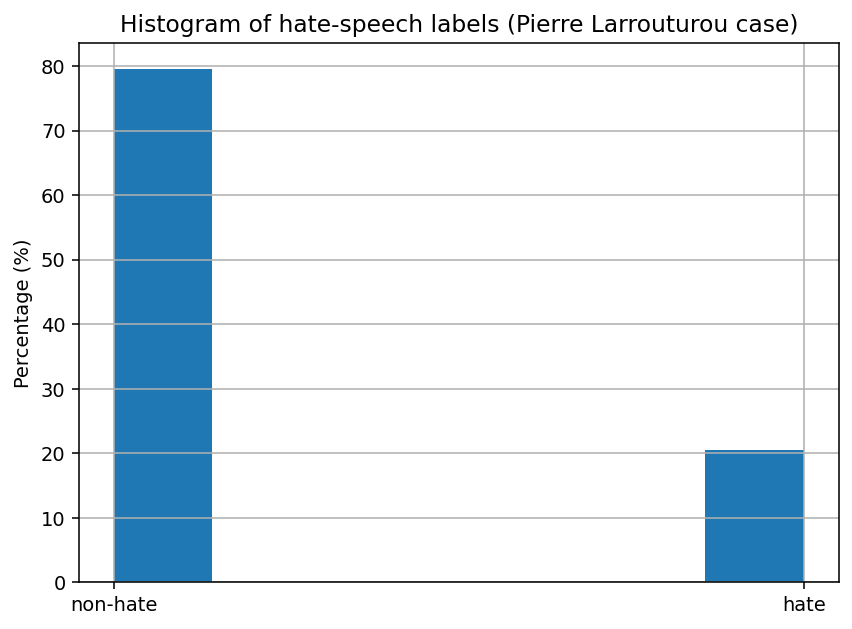

In [26]:
x = np.arange(n_labels)
bins = np.linspace(0, 1, 8)

fig, ax = plt.subplots (figsize=(7, 5), dpi=140)
plt.title ('Histogram of hate-speech labels (Pierre Larrouturou case)')
df1['tweetHate.score'].hist(bins=bins, weights=np.ones_like(df1[df1.columns[0]]) * 100. / len(df1))
plt.ylabel('Percentage (%)')
ax.set_xticks (x)
ax.set_xticklabels (list(labels_ids.keys()))
ax.grid(True)
plt.show ()

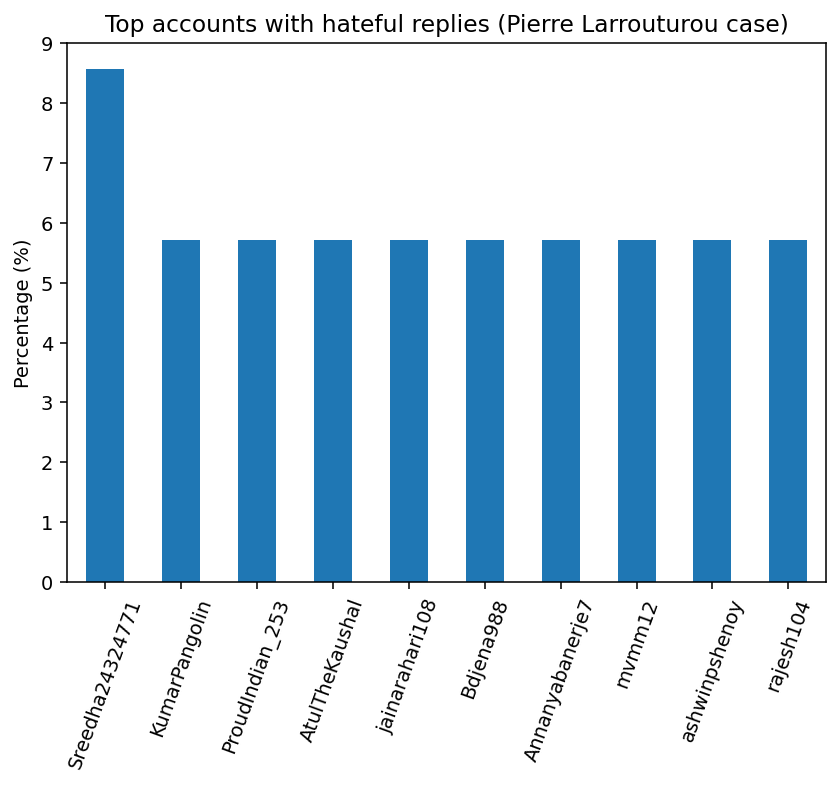

In [31]:
plt.figure(figsize=(7,5),dpi=140)

hate = df1 [df1['tweetHate.score'] == 1]
hate_percent = hate ['username'].value_counts()*100/len(hate)
hate_percent[:10].plot(kind='bar')

plt.xticks(rotation = 70)

plt.title('Top accounts with hateful replies (Pierre Larrouturou case)')
plt.ylabel('Percentage (%)')

plt.show()

Alviina Alametsä case

In [28]:
print ("Total number of negative sentiment content within the dataset", len(df2 [df2['tweetSentiment.score'] == 0]))
print ("Total number of neutral sentiment content within the dataset", len(df2 [df2['tweetSentiment.score'] == 1]))
print ("Total number of positive sentiment content within the dataset", len(df2 [df2['tweetSentiment.score'] == 2]))

Total number of negative sentiment content within the dataset 76
Total number of neutral sentiment content within the dataset 33
Total number of positive sentiment content within the dataset 4


In [37]:
print ("Percentage of negative sentiment content within the dataset", len(df2 [df2['tweetSentiment.score'] == 0])*100/len(df2),'%')
print ("Percentage of neutral sentiment content within the dataset", len(df2 [df2['tweetSentiment.score'] == 1])*100/len(df2),'%')
print ("Percentage of positive sentiment content within the dataset", len(df2 [df2['tweetSentiment.score'] == 2])*100/len(df2),'%')

Percentage of negative sentiment content within the dataset 67.2566371681416 %
Percentage of neutral sentiment content within the dataset 29.20353982300885 %
Percentage of positive sentiment content within the dataset 3.5398230088495577 %


In [29]:
print ("Total number of non-hateful content within the dataset", len(df2 [df2['tweetHate.score'] == 0]))
print ("Total number of hateful content within the dataset", len(df2 [df2['tweetHate.score'] == 1]))

Total number of non-hateful content within the dataset 72
Total number of hateful content within the dataset 41


In [38]:
print ("Percentage of non-hateful content within the dataset", len(df2 [df2['tweetHate.score'] == 0])*100/len(df2),'%')
print ("Percentage of hateful content within the dataset", len(df2 [df2['tweetHate.score'] == 1])*100/len(df2),'%')

Percentage of non-hateful content within the dataset 63.716814159292035 %
Percentage of hateful content within the dataset 36.283185840707965 %


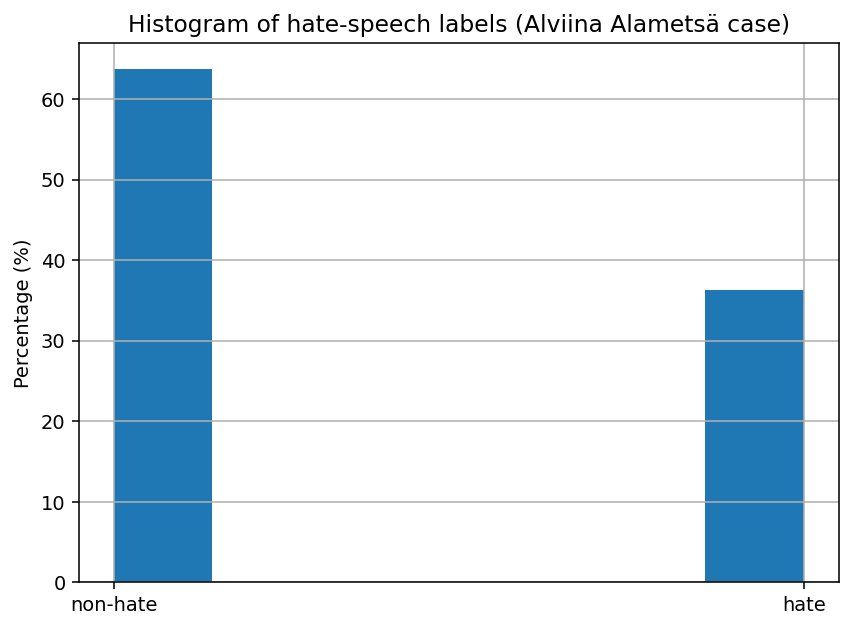

In [30]:
x = np.arange(n_labels)
bins = np.linspace(0, 1, 8)

fig, ax = plt.subplots (figsize=(7, 5), dpi=140)
plt.title ('Histogram of hate-speech labels (Alviina Alametsä case)')
df2['tweetHate.score'].hist(bins=bins, weights=np.ones_like(df2[df2.columns[0]]) * 100. / len(df2))
plt.ylabel('Percentage (%)')
ax.set_xticks (x)
ax.set_xticklabels (list(labels_ids.keys()))
ax.grid(True)
plt.show ()

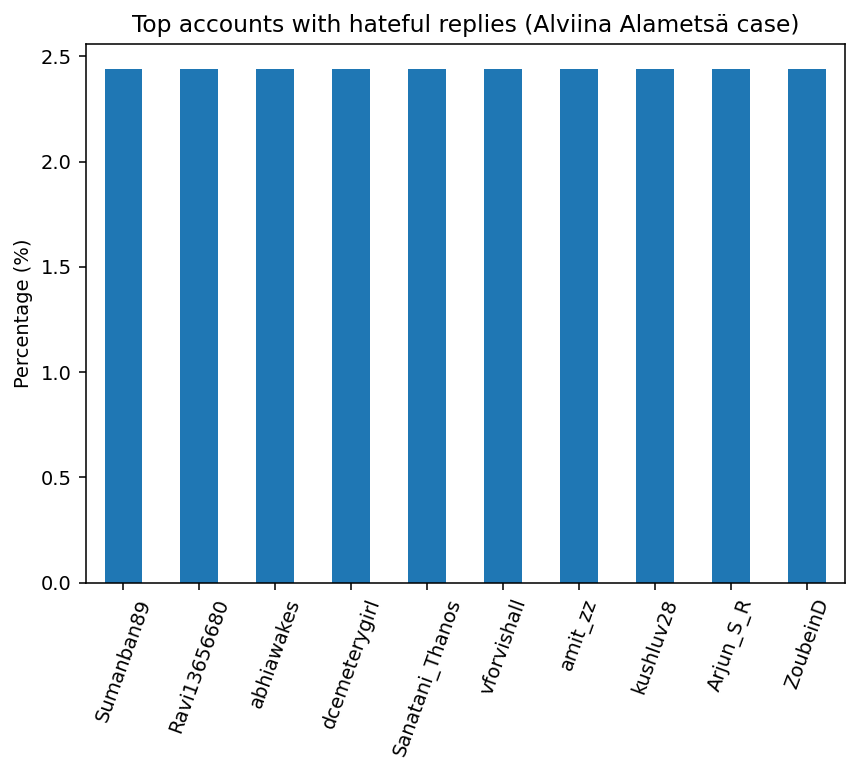

In [32]:
plt.figure(figsize=(7,5),dpi=140)

hate = df2 [df2['tweetHate.score'] == 1]
hate_percent = hate ['username'].value_counts()*100/len(hate)
hate_percent[:10].plot(kind='bar')

plt.xticks(rotation = 70)

plt.title('Top accounts with hateful replies (Alviina Alametsä case)')
plt.ylabel('Percentage (%)')

plt.show()